In [1]:
import matplotlib
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

%matplotlib inline

## Project Overview

For my capstone project, I aim to answer two business questions.

1. Are there differences in demographics between users who successfully complete offers, versus those who do not?
2. Can we predict whether a user will successfully complete an offer?

The motivation behind these questions is as follows. Being able to predict who will use offers allows Starbucks to better target its customers. An offer is a carrot on a stick for many customers, and it keeps them coming into the store influencing consumer behavior by building brand loyalty over time. But in that same vein, we also don’t want to send offers to those who 1) won’t use them, as over time they could feel like they are being spammed and 2) some users are happy to spend money without using an offer. If we gave these customers offers Starbucks would be losing money.

This capstone project is using data provided by Udacity as part of the Data Scientist Nanodegree course. It contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. The provided background information on the mobile app is that once every few days, Starbucks sends out an offer to users of the mobile app. Some users might not receive any offers during certain weeks, and not all users receive the same offer.

## Problem Statement
This project will address two questions. Firstly we will undertake an exploratory analysis of the differences in demographics between those customers who take up offers and those who don’t. Secondly, we will build a model to predict who will use the offers we are sending out.
We are provided with 3 datasets.

- Portfolio. Contains the offer characteristics.
- Demographics. Contains the demographic data for each user.
- Transcript. Contains the transactional records of all app events.

To answer the second question, we will use classification-based supervised machine learning models. To assess the performance of the model, we will keep an eye on accuracy but will predominantly use the F1 score. The F1 is more useful in cases where the dataset is unbalanced, and although we are balancing the dataset using SMOTE, the synthetic samples are still pulled from the same data distribution so we feel it is better to be cautious.

The F1 score is defined as the harmonic mean of precision and recall and focuses on positive cases. For our project, it would prioritize more on whether offers are successfully completed, and less focus on why offers are not completed.


## Transcript data

At first glance, this seemed simple. Filter rows to 'offer completed' and I've got my dataset to train my model. Boy was
I wrong! After reading the Udacity Mentor help I was directed to a post on Towards Data Science that helped me appreciate
the nuances of the data and how to categorise a successful offer. So credit to the author (Syuen Loh) for the assistance in
classifying a successful transaction.

https://towardsdatascience.com/using-starbucks-app-user-data-to-predict-effective-offers-20b799f3a6d5

To answer the research question, I need to define what constitutes a successful offer.

There are four events (offer completed, offer received, offer viewed and transaction), but there are no events types
for one of our events (Transactions). Therefore we first need to work out how we can assign offer_id's to certain
transactions.

We can also see that bogo and discount offers have offer completed events but informational ones do not. Therefore we
also need to work out how to define an successful offer in this case.

### Defining successful offers

For a bogo and discount offer, a successful offer would be defined if the following events were recorded in the right
sequence in time:

`offer received` -> `offer viewed` -> `transaction` -> `offer completed`

Meanwhile, for an informational offer, since there is no offer completed event associated with it, we will have to define
transactions as a conversion to successful offer:

`offer received` -> `offer viewed` -> `transaction`

## Assigning offer ids to transactions
After defining the approach above, we now have to explore methods to assign offer_ids to specific transactions. Among the considerations is to define the following main groups of customers:

### 1. People who are influenced and successfully convert

- `offer received` -> `offer viewed` -> `transaction` -> `offer completed` (bogo/discount offers)
- `offer received` -> `offer viewed` -> `transaction` (informational offers - must be within validity period of offer)

Our group 1 customers are the people we are after. They use the offers that Starbucks send out and we want ot be able to separate
them from the other customers!

#### transcript.json

- event (str) - record description (ie transaction, offer received, offer viewed, etc.)
- person (str) - customer id
- time (int) - time in hours since start of test. The data begins at time t=0
- value - (dict of strings) - either an offer id or transaction amount depending on the record

In [2]:
# load in data
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Rename col names
transcript.rename(columns={"person": "customer_id", "time": "time_h"}, inplace=True)

In [3]:
# There are 4 different events
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [4]:
# Pull offer id, value and reward out of value column
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)

In [5]:
# combine duplicates names of 'offer id' and 'offer_id'
transcript['offer_id_new']=np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])

#drop unnecessary offer_id columns
transcript.drop(['offer id','offer_id'],axis=1,inplace=True)

#rename offer_id column
transcript.rename(columns={'offer_id_new':'offer_id'},inplace=True)

transcript.head()

,customer_id,event,value,time_h,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [6]:
# sort values by customer_id and by time
transcript=transcript.sort_values(['customer_id','time_h'])

# Change offer names to something more readable
event_map ={
'offer received':1,
'offer viewed':2,
'transaction':3,
'offer completed':4,}

transcript['event'] = transcript['event'].map(event_map)

In [7]:
list_unique_customers = transcript['customer_id'].unique()

Create a subset of the data, loop through each unique customer in the dataset['event'] and identify the sequence (1,2,3,4).

They are our group 1 members and have successfully completed either a bogo or discount offer.

In [8]:
subset_data = transcript[['customer_id', 'event']]

members1 = pd.DataFrame([])

for customer in list_unique_customers:
    customer_data = subset_data[subset_data['customer_id'] == customer]
    grp1_pat = np.asarray([1, 2, 3, 4])
    grp1_N = len(grp1_pat)
    grp_members = (customer_data['event'].rolling(window=grp1_N , min_periods=grp1_N)
                  .apply(lambda x: (x==grp1_pat).all())
                  .mask(lambda x: x == 0)
                  .bfill(limit=grp1_N-1)
                  .fillna(0)
                  .astype(bool))
    members1 = members1.append(pd.DataFrame(grp_members))


In [9]:
# merge the boolean members column into the transcript dataframe
transcript = pd.merge(transcript, members1, left_index=True, right_index=True)
transcript.rename(columns={'event_y':'grp1_members'},inplace=True)


Create a subset of the data, loop through each unique customer in the dataset['event'] and identify the sequence (1,2,3).

They are our group 2 members and have successfully completed either an informational, bogo or discount offer. We will need to split these groups up later!

In [10]:
subset_data = transcript[['customer_id', 'event_x', 'grp1_members']]

members2 = pd.DataFrame([])

for customer in list_unique_customers:
    customer_data = subset_data[(subset_data['customer_id'] == customer)]
    grp1_pat = np.asarray([1, 2, 3])
    grp1_N = len(grp1_pat)
    grp_members = (customer_data['event_x'].rolling(window=grp1_N , min_periods=grp1_N)
                  .apply(lambda x: (x==grp1_pat).all())
                  .mask(lambda x: x == 0)
                  .bfill(limit=grp1_N-1)
                  .fillna(0)
                  .astype(bool))
    members2 = members2.append(pd.DataFrame(grp_members))


In [11]:
# merge members into transcript
transcript = pd.merge(transcript, members2, left_index=True, right_index=True)

In [12]:
# rename columns as a result of the merge
transcript.rename(columns={'event_x_x':'event', 'event_x_y': 'grp2_members'},inplace=True)

In [13]:
# select only grp 1 and grp 2 members
offer_success_df = transcript[(transcript['grp1_members'] == True) | (transcript['grp2_members'] == True)]

In [14]:
# forward fill offer id into transaction rows(event = 3)
offer_success_df['offer_id'] = offer_success_df['offer_id'].ffill()
# offer_success_df.to_pickle('offer_success.pkl', compression='gzip')
offer_success_df.head()

c:\users\timot\.virtualenvs\capstonev3-gkkpizcc\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,customer_id,event,value,time_h,amount,reward,offer_id,grp1_members,grp2_members
55972,0009655768c64bdeb2e877511632db8f,1,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True
77705,0009655768c64bdeb2e877511632db8f,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True
89291,0009655768c64bdeb2e877511632db8f,3,{'amount': 22.16},228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True
56475,00116118485d4dfda04fdbaba9a87b5c,1,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},168,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,False,True
85769,00116118485d4dfda04fdbaba9a87b5c,2,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},216,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,False,True


### Portfolio data
Describes the characteristics of each offer, inc. its duration and the amount a customer needs to spend to complete
it (difficulty).

We don't need to do much with this dataset, besides converting the categorical variables to dummies. We will do this,
but I don' foresee we will actually use these variables.

#### portfolio.json

- id (string) - offer id
- offer_type (string) - type of offer ie BOGO, discount, informational
- difficulty (int) - minimum required spend to complete an offer
- reward (int) - reward given for completing an offer
- duration (int) - time for offer to be open, in days
- channels (list of strings)

In [15]:
# Read in portfolio data
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)

In [16]:
# Get dummies for offer types
portfolio.rename(columns={"id": "offer_id"}, inplace=True)
portfolio['dum_offer_type'] = portfolio['offer_type']
portfolio = pd.get_dummies(portfolio, columns=['offer_type'])
portfolio.rename(columns={"dum_offer_type": "offer_type"}, inplace=True)

In [17]:
# get dummies for channels
channel_data = portfolio['channels']
mlb = MultiLabelBinarizer()
dummy_channels = pd.DataFrame(mlb.fit_transform(channel_data),columns=mlb.classes_, index=portfolio.index)
portfolio = portfolio.join(dummy_channels)
portfolio.drop(columns=['channels'], inplace=True)
portfolio.head()

,reward,difficulty,duration,offer_id,offer_type,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,1,0,0,1,1,1,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,1,0,0,1,1,1,1
2,0,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,0,1,1,1,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,1,0,0,1,1,0,1
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,0,1,0,1,0,0,1


### Merge transcript data with portfolio data
We will merge in the portfolio data just in case we need it.

In [18]:
transcript_portfolio_df = pd.merge(offer_success_df, portfolio, on='offer_id')
transcript_portfolio_df.head()

,customer_id,event,value,time_h,amount,reward_x,offer_id,grp1_members,grp2_members,reward_y,difficulty,duration,offer_type,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,0009655768c64bdeb2e877511632db8f,1,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True,0,0,3,informational,0,0,1,1,1,1,0
1,0009655768c64bdeb2e877511632db8f,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True,0,0,3,informational,0,0,1,1,1,1,0
2,0009655768c64bdeb2e877511632db8f,3,{'amount': 22.16},228,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True,0,0,3,informational,0,0,1,1,1,1,0
3,0020ccbbb6d84e358d3414a3ff76cffd,1,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True,0,0,3,informational,0,0,1,1,1,1,0
4,0020ccbbb6d84e358d3414a3ff76cffd,2,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},408,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,False,True,0,0,3,informational,0,0,1,1,1,1,0


## Split the data into a bogo/discount group and an informational group.
Split data into group 1 and 2. We know that the group 1 members (BOGO and discount offers) successfully completed the
offer in the correct timeframe due to the `offer completed` flag, but we don't have this for the group 2 members (infomrational)
so we need to check this independently.

In [19]:
grp1_ = transcript_portfolio_df[transcript_portfolio_df['grp1_members'] == True]
grp2_ = transcript_portfolio_df[transcript_portfolio_df['grp1_members'] != True]

We loop through the grp2_ data in blocks of 3 (to account for the 3 event sequence) and calculate the duration between the offer received and transaction events. If the delta is less than or equal to the duration of the offer then we deem it a success and save the transaction row.

In [20]:
grp_2_success = pd.DataFrame()

for i in range(0, (len(grp2_)-2), 3):
    row1 = grp2_.iloc[i, :]
    row3 = grp2_.iloc[i+2, :]
    time_limit = row1['duration']*24
    time_h = row3['time_h'] - row1['time_h']
    if time_h <= time_limit:
        grp_2_success = grp_2_success.append(row3)


In [21]:
# Limit the dataset to only transaction events
grp_1_success = grp1_[grp1_['event'] == 3]

In [22]:
# concatenate the groups back together
successful_offer_transactions = pd.concat([grp_1_success, grp_2_success])
# successful_offer_transactions.to_pickle('successful_offer_transactions.pkl', compression='gzip')
successful_offer_transactions.head()

,customer_id,event,value,time_h,amount,reward_x,offer_id,grp1_members,grp2_members,reward_y,difficulty,duration,offer_type,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
26,00b3400e4ff64ee68ce9ada1d0c222f0,3.0,{'amount': 23.88},420.0,23.88,NaN,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0
77,017febbe52e64ac19cf28cf0d44386e4,3.0,{'amount': 31.02},510.0,31.02,NaN,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0
173,03f1ad04292f47b2b1299cc92f8f2a5d,3.0,{'amount': 25.3},588.0,25.30,NaN,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0
176,041967ceb80841ddbd306958d4f744ac,3.0,{'amount': 26.8},576.0,26.80,NaN,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0
281,0632e74a24484c819d06eb086298c406,3.0,{'amount': 17.99},600.0,17.99,NaN,5a8bc65990b245e5a138643cd4eb9837,1.0,1.0,0.0,0.0,3.0,informational,0.0,0.0,1.0,1.0,1.0,1.0,0.0


## Data Exploration
### Count of transactions from successful offers by offer type
It would seem that the bogo offer was most frequently used by customers followed closely by the discount offers.
the informational offers were the least used by customers.

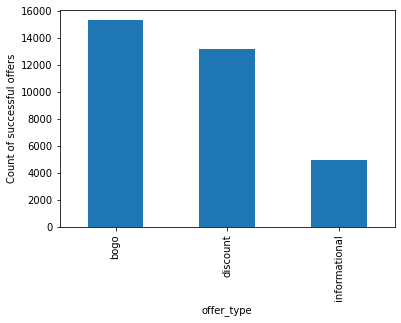

In [23]:
ax = successful_offer_transactions['offer_type'].value_counts().plot.bar();
ax.set_ylabel('Count of successful offers');
ax.set_xlabel('offer_type');

In [24]:
subset = successful_offer_transactions[['amount','offer_type']]
sum_trans = subset.groupby('offer_type').agg(['sum'])
count_trans = subset.groupby('offer_type').agg(['count'])

### Total transaction amount by offer type
Unsurprisingly, given it was the most used offer type, the bogo offer type also brought in the most money.

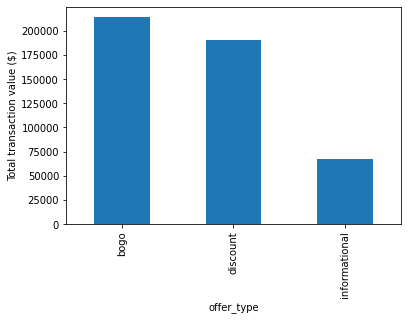

In [25]:
ax1 = sum_trans.plot.bar(legend=False);
ax1.set_ylabel('Total transaction value ($)');

### Average transaction value
Although we see more bogo and discount offers, and therefore the total values of these offers types are larger, the average
value for each of the offers is very similar. The discount offer results in the largest average transaction values. In
general I think this shows that all offers are equally effective.

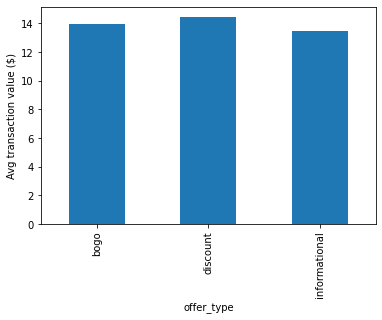

In [26]:
avg_transaction_amount = pd.DataFrame(sum_trans.values/count_trans.values)
avg_transaction_amount.rename(columns={0: 'Avg ($) per transaction'}, index={0: 'bogo', 1: 'discount', 2: 'informational'})
ax2 = avg_transaction_amount.plot.bar(legend = False)
ax2.set_xticklabels(['bogo', 'discount', 'informational'], rotation=90)
ax2.set_ylabel('Avg transaction value ($)');
ax2.set_xlabel('offer_type');

### Number of unique customers per offer type

In [27]:
bogo_unique_cust = successful_offer_transactions[successful_offer_transactions['offer_type'] == 'bogo']['customer_id'].nunique()
disc_unique_cust= successful_offer_transactions[successful_offer_transactions['offer_type'] == 'discount']['customer_id'].nunique()
info_unique_cust = successful_offer_transactions[successful_offer_transactions['offer_type'] == 'informational']['customer_id'].nunique()

print('The bogo offer had {} unique customers'.format(bogo_unique_cust))
print('The discount offer had {} unique customers'.format(disc_unique_cust))
print('The informational offer had {} unique customers'.format(info_unique_cust))

The bogo offer had 10398 unique customers
The discount offer had 9442 unique customers
The informational offer had 4281 unique customers


### Number of transactions by offer_id

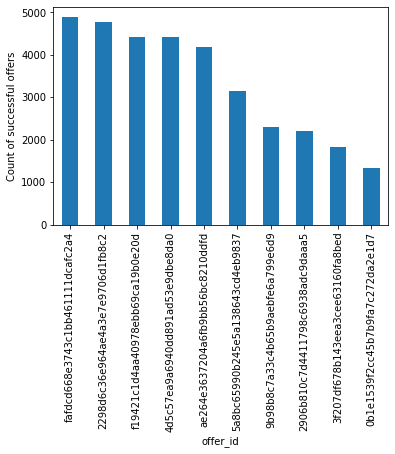

In [28]:
ax3 = successful_offer_transactions['offer_id'].value_counts().plot.bar();
ax3.set_ylabel('Count of successful offers');
ax3.set_xlabel('offer_id');

### Total transaction amount by offer id
Unsurprisingly, given it was the most used offer type, the bogo offer type also brought in the most money.

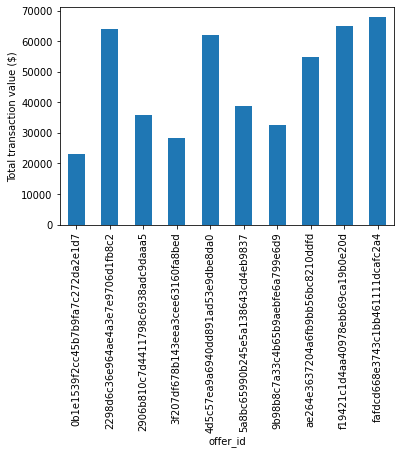

In [29]:
subset_oids = successful_offer_transactions[['amount','offer_id']]
sum_trans_oids = subset_oids.groupby('offer_id').agg(['sum'])
count_trans_oids = subset_oids.groupby('offer_id').agg(['count'])

ax4 = sum_trans_oids.plot.bar(legend=False);
ax4.set_ylabel('Total transaction value ($)');


### Average transaction value by offer id
The least used offer (`0b1e1539f2cc45b7b9fa7c272da2e1d7`), resulted in the most value for starbucks. All offers resulted in
an average transaction value greater than $12.50.

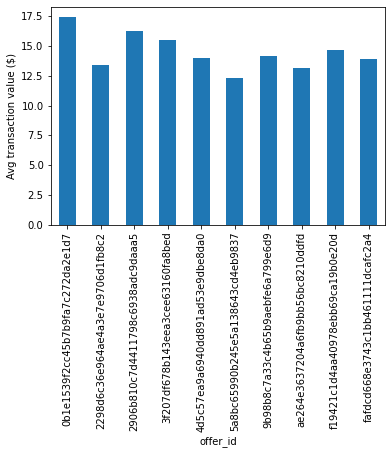

In [30]:
avg_transaction_amount_oids = pd.DataFrame(sum_trans_oids.values/count_trans_oids.values)
avg_transaction_amount_oids.rename(columns={0: 'Avg ($) per transaction'})
ax5 = avg_transaction_amount_oids.plot.bar(legend = False)
ax5.set_xticklabels(['0b1e1539f2cc45b7b9fa7c272da2e1d7',
                     '2298d6c36e964ae4a3e7e9706d1fb8c2',
                     '2906b810c7d4411798c6938adc9daaa5',
                     '3f207df678b143eea3cee63160fa8bed',
                     '4d5c57ea9a6940dd891ad53e9dbe8da0',
                     '5a8bc65990b245e5a138643cd4eb9837',
                     '9b98b8c7a33c4b65b9aebfe6a799e6d9',
                     'ae264e3637204a6fb9bb56bc8210ddfd',
                     'f19421c1d4aa40978ebb69ca19b0e20d',
                     'fafdcd668e3743c1bb461111dcafc2a4'], rotation=90)
ax5.set_ylabel('Avg transaction value ($)');
ax5.set_xlabel('offer_id');

In [31]:
# Get list of the unique customers who are using the offers.
customers_who_use_offers = successful_offer_transactions['customer_id'].unique()
customers_who_use_offers[0:5]

array(['00b3400e4ff64ee68ce9ada1d0c222f0',
       '017febbe52e64ac19cf28cf0d44386e4',
       '03f1ad04292f47b2b1299cc92f8f2a5d',
       '041967ceb80841ddbd306958d4f744ac',
       '0632e74a24484c819d06eb086298c406'], dtype=object)

# Our customers!
Back to our project aim - predicting which customers we should be sending offers too!

We have our dataframe of successful transactions. If we take all unique customers from this dataset we have a list of customers
who are likely to respond to our offers. Those who aren't in the list can be considered customers who may not respond.

We will do some further exploratory analyses on how these groups of customers may differ. We will first need to load in the
profile data

**profile.json**

- age (int) - age of the customer
- became_member_on (int) - date when customer created an app account
- gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
- id (str) - customer id
- income (float) - customer's income

In [32]:
# Load in data
profile = pd.read_json('data/profile.json', orient='records', lines=True)

# rename id column to align with transcript dataset
profile.rename(columns={"id": "customer_id"}, inplace=True)

#drop null values and duplicates - this gets rid of nan and values where age == 118
profile.dropna(inplace=True)
profile.drop_duplicates(inplace=True)

# create dummy vars for model
profile['gender_temp'] = profile['gender']
profile = pd.get_dummies(profile, columns=['gender'])

# convert date into an more easy to use field.
profile['date_joined'] = pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile['year'] = pd.DatetimeIndex(profile['date_joined']).year
profile['month'] = pd.DatetimeIndex(profile['date_joined']).month
profile.drop(columns=['became_member_on'], inplace=True)

profile['membership_duration'] = profile['date_joined'].apply(lambda x: pd.Timedelta(pd.Timestamp.now() - x, unit='days'))
profile['membership_duration'] = (profile["membership_duration"]).dt.days
profile.head()


,age,customer_id,income,gender_temp,gender_F,gender_M,gender_O,date_joined,year,month,membership_duration
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,F,1,0,0,2017-07-15,2017,7,1346
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,F,1,0,0,2017-05-09,2017,5,1413
5,68,e2127556f4f64592b11af22de27a7932,70000.0,M,0,1,0,2018-04-26,2018,4,1061
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,M,0,1,0,2018-02-09,2018,2,1137
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,M,0,1,0,2017-11-11,2017,11,1227


### What more can we do?
We don't have many usable features to characterise our customers yet. We currently have;

1. Age
2. Income
3. Gender
4. Membership duration (this will capture the variance in the other date metrics)

Perhaps we can create some more based on the transcript data?

5. Number of previous transactions?
6. Total value of transactions?
7. Spend per transaction?
8. Previously used our offers?


In [33]:
# I'm reloading this as I've manipulated the other version of this data
transcript_reload = pd.read_json('data/transcript.json', orient='records', lines=True)
transcript_reload.rename(columns={"person": 'customer_id'}, inplace=True)
transcript_transactions = transcript_reload[transcript_reload['event'] == 'transaction']
transcript_transactions=pd.concat([transcript_transactions, transcript_transactions['value'].apply(pd.Series)], axis=1)
transcript_transactions.drop(columns=['event', 'value', 'time'], inplace=True)


In [34]:
# Calculate new features (5 and 6 from above)
new_customer_features = transcript_transactions.groupby('customer_id').agg(['sum', 'count'])

In [35]:
# merge tables and rename new features
profile_new_feats = pd.merge(profile, new_customer_features, on='customer_id', how='left')
profile_new_feats.rename(columns={('amount', 'sum'): 'total_spend', ('amount','count'): 'num_transactions'}, inplace=True)

c:\users\timot\.virtualenvs\capstonev3-gkkpizcc\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [36]:
# Calculate new feature to capture avg spend per transaction (number 7 above
profile_new_feats['avg_spend'] = profile_new_feats['total_spend']/profile_new_feats['num_transactions']

In [37]:
# create new feature to capture if they have previously successful used an offer (number 8 above)
profile_new_feats['used_prev_offers'] = profile_new_feats['customer_id'].apply(lambda x: True if x in customers_who_use_offers else False)

In [38]:
# The sum ot the True and False values should equal the total number of unique customers which they do :-)
print(profile_new_feats['used_prev_offers'].value_counts())
print(profile['customer_id'].nunique())

True     13017
False     1808
Name: used_prev_offers, dtype: int64
14825


## Exploratory analysis of profile data

Of all the customers in the profile database, 87.8% of them actually use the offers Starbucks send them. The remaining 12.2%
either need no encouragement to spend money at Starbucks and therefore we don't want to give them any discounts, unless
their loyalty is to be rewarded, or they just aren;t interested in offers and we don't want to annoy them. Although 12.2% seems
small compared to 87.8%, I bet its still a large chunk of change! Lets see.

### Transaction value by those who use offers and those who don't

Text(0, 0.5, 'Total value ($)')

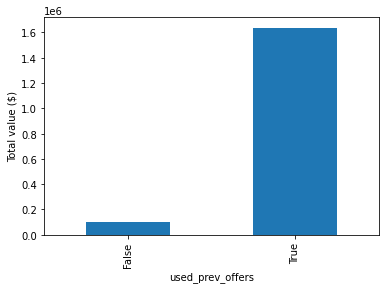

In [39]:
# Those who use the offers bring in 1.6 million dollars, while those who don't bring in $100k. Not as much as I would have thought,
# but still, better to have it then not to have it.
ax6 = profile_new_feats[['total_spend','used_prev_offers']].groupby('used_prev_offers').agg(['sum']).plot.bar(legend=False)
ax6.set_ylabel('Total value ($)')

### Age by those who use offers and those who don't

used_prev_offers
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

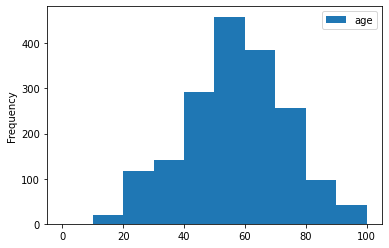

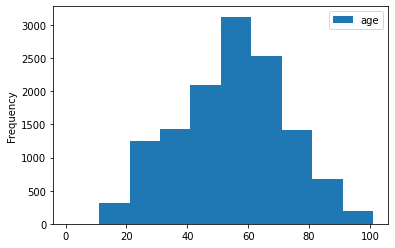

In [40]:
# Apart from their being many more people in the true group, the distributions are quote similar.
profile_new_feats[['age','used_prev_offers']].groupby('used_prev_offers').plot.hist()

### Income by those who use offers and those who don't
There seems to be a larger proportion of people in the false group (top) compared to the true group (bottom) for the higher
earners e.g. those with a salary above 80000k

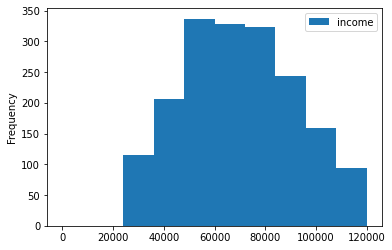

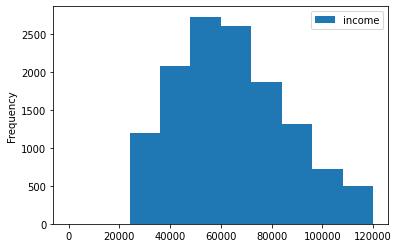

In [41]:
ax7 = profile_new_feats[['income','used_prev_offers']].groupby('used_prev_offers').plot.hist()

### Gender by those who use offers and those who don't
Fairly well balanced on gender

In [42]:
profile_new_feats[['gender_temp','used_prev_offers']].value_counts()


gender_temp  used_prev_offers
M            True                7457
F            True                5373
M            False               1027
F            False                756
O            True                 187
             False                 25
dtype: int64

### Membership duration by those who use offers and those who don't
There is a larger proportion of those who use offers (bottom) when they have been a member for longer.

used_prev_offers
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

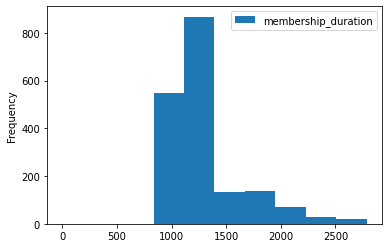

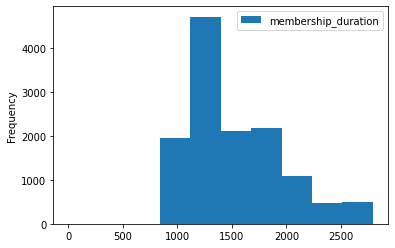

In [43]:
profile_new_feats[['membership_duration','used_prev_offers']].groupby('used_prev_offers').plot.hist()


### Number of previous transactions by those who use offers and those who don't
There is a greater proportion of people with more transactions for those who use offers than those who do not.

used_prev_offers
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

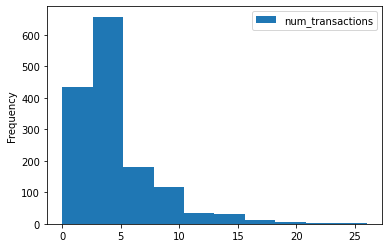

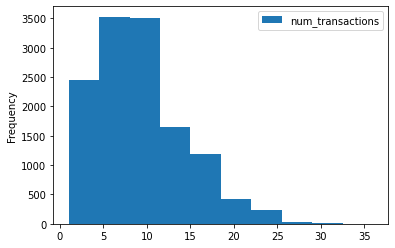

In [44]:
profile_new_feats[['num_transactions','used_prev_offers']].groupby('used_prev_offers').plot.hist()

### Number of previous transactions by those who use offers and those who don't
There are not many differences between avg spend

used_prev_offers
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

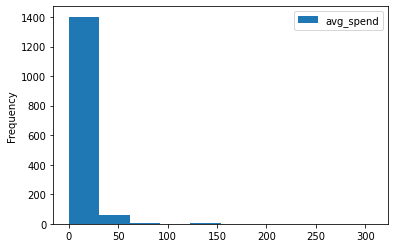

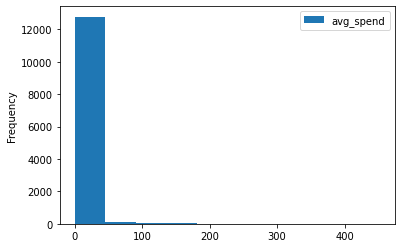

In [45]:
profile_new_feats[['avg_spend','used_prev_offers']].groupby('used_prev_offers').plot.hist()

### Number of previous transactions by those who use offers and those who don't
There are not many differences between avg spend

used_prev_offers
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

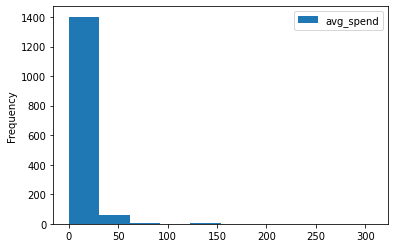

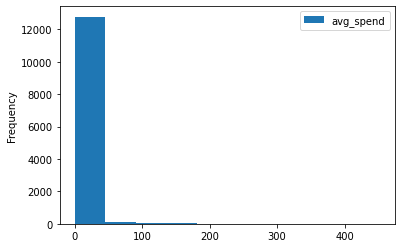

In [46]:
profile_new_feats[['avg_spend','used_prev_offers']].groupby('used_prev_offers').plot.hist()

## Final steps to get the data ready for the model

Lets drop the columns we don't need. We also have a few nans, where the number of transactions, avg spend and total spend
are 0 so we will replace these nans with 0s.

In [47]:
profile_new_feats[['num_transactions', 'avg_spend','total_spend']] = profile_new_feats[['num_transactions', 'avg_spend','total_spend']].fillna(0)

In [48]:
profile_new_feats.drop(['gender_temp','date_joined', 'year', 'month', 'customer_id'],axis=1,inplace=True)
y = profile_new_feats['used_prev_offers']
X = profile_new_feats.drop(columns=['used_prev_offers'])

The classes are unbalanced, we will use SMOTE resampling to re-balance the dataset.

In [49]:
method = SMOTE() # we will create synthetic samples for the minority class
X_resampled, y_resampled = method.fit_resample(X, y)
y_resampled.value_counts() # classes are now balanced

False    13017
True     13017
Name: used_prev_offers, dtype: int64

Create our training and testing data

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,  test_size=0.3, random_state=45)

## Create our model pipeline for Random Forest

In [51]:
def model_pipeline():
    numeric_features = ['age', 'income', 'membership_duration', 'total_spend', 'num_transactions', 'avg_spend']
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestClassifier())])

    # CV params
    parameters = {'clf__criterion': ["gini", "entropy"],
                  'clf__max_features': ['auto', 'sqrt', 'log2'],
                  'clf__max_depth': [2, 4, 8, 16, 32, None],
                  'clf__n_estimators': [5, 10, 50, 100, 250]}

    cv = GridSearchCV(clf, param_grid=parameters, n_jobs=-1)
    return cv

In [52]:
model = model_pipeline()  # instantiate pipeline with gridsearchCV included
model.fit(X_train, y_train)
print(model.best_params_)

print("model score: %.3f" % model.score(X_test, y_test))

{'clf__criterion': 'entropy', 'clf__max_depth': None, 'clf__max_features': 'log2', 'clf__n_estimators': 250}
model score: 0.923


In [53]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))# predict on test data

              precision    recall  f1-score   support

       False       0.95      0.89      0.92      3941
        True       0.90      0.95      0.92      3870

    accuracy                           0.92      7811
   macro avg       0.92      0.92      0.92      7811
weighted avg       0.92      0.92      0.92      7811



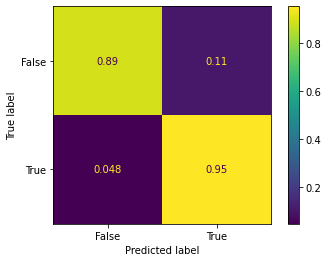

In [54]:
plot_confusion_matrix(model, X_test, y_test, normalize='true');

## Create our model pipeline for Adaboost forest

In [55]:
def model_pipeline():
    numeric_features = ['age', 'income', 'membership_duration', 'total_spend', 'num_transactions', 'avg_spend']
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)])

    clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', AdaBoostClassifier())])

    # CV params
    parameters = {'clf__learning_rate': [0.001, 0.01, 0.1, 1.0],
                  'clf__n_estimators': [10, 50, 100, 250, 500]}

    cv = GridSearchCV(clf, param_grid=parameters, n_jobs=-1)
    return cv

model = model_pipeline()  # instantiate pipeline with gridsearchCV included
model.fit(X_train, y_train)
# print(model.get_params().keys())

print("model score: %.3f" % model.score(X_test, y_test))

model score: 0.902


In [56]:
print(model.best_params_)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))# predict on test data

{'clf__learning_rate': 1.0, 'clf__n_estimators': 500}
              precision    recall  f1-score   support

       False       0.96      0.84      0.90      3941
        True       0.86      0.96      0.91      3870

    accuracy                           0.90      7811
   macro avg       0.91      0.90      0.90      7811
weighted avg       0.91      0.90      0.90      7811



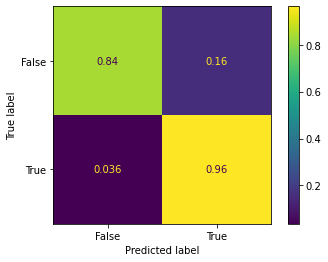

In [57]:
plot_confusion_matrix(model, X_test, y_test, normalize='true');
